#CSE 151A Project EDA

Github link: https://github.com/jkaminsky2/CSE-151A-Project-

TODO 2/8 (before Sunday)
1. Upload it to Github when we're done **(Emily - Sunday evening at 9PM?)**
2. Add any personal copy code to this notebook
3. Write our README (how did we preprocess the data)
- **Emily**: added categories of restaurants, translated review text, added language of review text, etc.
- **Joey**: conversing with creator of dataset to fix error, sentiment analysis, describing columns, finding price-related words, and finding the emotional tone of the reviews.
- **Christine**:
1. Creating a Geographical Data Frame
We initiate a new data frame exclusively for handling geographical information related to restaurants. This allows us to streamline and centralize all location-based data.
2. GPS Coordinates Conversion
We convert the GPS coordinates provided in string format ([latitude, longitude]) into two separate columns, namely latitude and longitude.
3. KMeans Clustering
To identify patterns and group restaurants with similar geographical locations, we implement KMeans clustering. Currently, the number of clusters is set to 200, which can be changed later.
4. Location Object Generation
We leverage the GPS pairs to generate a detailed location object for each restaurant. This object includes essential geographical information such as the road, city, postal code, and country.
5. Hot-Encoding Price Bracket
In addition to geographical details, we hot-encode the price bracket of each restaurant.
- **Viraj:** time strings to time objects
- **Risab/maybe someone else:** imputation of nulls

4. Add disclaimer for no scatterplot (Armaan). Also add data distribution explanations

Optional:
- Figure out a way to save/store data locally/as a file so we don't have to keep downloading
- **Sebastian**: Create geographic/cartographic vs price scatter plot

Responsibilities:
- Emily: Number of Observations ✅, categories of restaurants ✅
- Joey: Sentiment Analysis/Description + "good deal"/"overpriced"/etc. ✅, Column Descriptions ✅
- Qingtong (Christine): geographic area ⭕, price labels (making the string of '$$' into ordinal categories) ⭕ **(starting tmrw afternoon)**
- Viraj: Scales ✅, Time objects ✅
- Armaan: Data Distribution **Plots** ✅, Normalization/Standardization ✅
- Risab: Missing data ⭕, imputation of nulls ⭕ **(working on it today)**
- Justin: Evaluate data ✅, Breaking down name - most common words, word counts of restaurant names, average price association with every word ✅

### Imports:

In [ ]:
#Add imports here as needed
import pandas as pd
import numpy as np
import json
import urllib
import requests
import gzip
import ast
from collections import Counter
import re
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


## Loading data:

### Loading place data

In [ ]:
data_link = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/googlelocal/places.clean.json.gz'

In [ ]:
def load_place(line, place_list):
  #Read a line, remove parsing characters like /n, 'b, u"
  place = line.decode('utf-8').strip().replace('u"', '"')

  #Place is now a dictionary
  place = ast.literal_eval(place)

  #Remove unnecessary keys (hours, phone)
  place.pop('hours', None)
  place.pop('phone', None)

  #Append place to the list
  place_list.append(place)

In [ ]:
place_list = [] #Store in empty list

response = urllib.request.urlopen(data_link) #Open the file at the link

with gzip.open(response, 'rb') as f:
  for line in f:
    load_place(line, place_list=place_list)

#Time to load: 5m 41s
#You may have to restart your runtime to get 5m runtime! If it's 8m>, something is wrong -- you should try again. Make sure your RAM graph looks accurate/fine.

In [ ]:
places = pd.DataFrame(place_list) #Converting to dataframe #Time = 9s

### Loading review data

In [ ]:
data_link = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/googlelocal/reviews.clean.json.gz'

In [ ]:
def load_review(line, review_list):
  #Read a line, remove parsing characters like /n, 'b, u"
  review = line.decode('utf-8').strip().replace("u'", "'")

  #Place is now a dictionary
  review = ast.literal_eval(review)

  #Remove unnecessary keys (hours, phone)
  review.pop('reviewerName', None)
  review.pop('phone', None)
  review.pop('gPlusUserId')

  #Append place to the list
  review_list.append(review)

In [ ]:
review_list = [] #Store in empty list

response = urllib.request.urlopen(data_link) #Open the file at the link

with gzip.open(response, 'rb') as f:
  #We want to get 5000 reviews to start
  for i in range(5_000):
    line = f.readline()
    load_review(line, review_list=review_list)

#Time to load data: 4s

In [ ]:
reviews = pd.DataFrame(review_list)

### Merge dataframes together

In [ ]:
reviews.head(2)

,rating,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime
0,3.0,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,1.372687e+09,"Jul 1, 2013"
1,5.0,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,1.342871e+09,"Jul 21, 2012"


In [ ]:
places.head(2)

,name,price,address,closed,gPlusPlaceId,gps
0,Diamond Valley Lake Marina,None,"[2615 Angler Ave, Hemet, CA 92545]",False,104699454385822125632,"[33.703804, -117.003209]"
1,Blue Ribbon Cleaners,None,"[Parole, Annapolis, MD]",False,103054478949000078829,"[38.979759, -76.547538]"


In [ ]:
#Left join since we want only restaurants associated with the reviews
comp = reviews.merge(places, how='left', on='gPlusPlaceId')

#Time to merge: 6s

In [ ]:
comp['reviewTime'] = pd.to_datetime(comp['reviewTime'])

In [ ]:
comp['unixReviewTime'] = pd.to_datetime(comp['unixReviewTime'], unit='s')

In [ ]:
type(comp['gps'].iloc[0])

list

# EDA:
- evaluate your data (What does each row, column mean? Is the data organized?) - JUSTIN
- number of observations (per price $, per area, etc. -- whatever you think is significant) - EMILY
- details about your data distributions (show plot) - ARMAAN
- scales (min max values for everything) - VIRAJ
- missing data, - RISAB
- column descriptions - JOEY

## Number of Observations (EMILY)

### Observing numbers of ratings, restaurants, and nulls in dataset

In [ ]:
!pip install install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=c78d83e86e00290fc53e6f77a2bdd1df9362eb9e42f40094a675bb271c58e214
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [ ]:
from googletrans import Translator

In [ ]:
#Number of restaurants in 5000 reviews
comp.groupby('gPlusPlaceId').count().shape[0]

#Given a left join table with 5,000 reviews, there are 4,978 unique restaurants

4978

In [ ]:
#Ratings per restaurant
comp.groupby('gPlusPlaceId').count()['rating'].value_counts()

#Given 5,000 reviews, most restaurants are only reviewed once.
#Only 22 restaurants are reviewed twice (which validates our above finding of 4,978 unique places.)

1    4956
2      22
Name: rating, dtype: int64

In [ ]:
#Number of nulls in the dataframe:
comp.isnull().sum()

#Lots of empty/null reviews (expected, some users only rate */5 with no explanation)
#A lot of empty prices...which isn't great for our problem :/

rating               0
reviewText        1527
categories         348
gPlusPlaceId         0
unixReviewTime     303
reviewTime         303
name                 1
price             3803
address              1
closed               1
gps                 15
dtype: int64

### Translating reviews:

In [ ]:
#translator = Translator()
#
#print(translator.translate('안녕하세요.'))
#
#print(translator.translate('이 문장은 한글로 쓰여졌습니다.').src)
#print(translator.translate('이 문장은 한글로 쓰여졌습니다.').text)

In [ ]:
#Check language function
def check(word):
  translator=Translator()
  result = translator.translate(word)
  return [result.src, result.text]

In [ ]:
reviewLang = comp.reviewText.apply(check) #This took 9m 15s to run

ReadTimeout: The read operation timed out

In [ ]:
translated = pd.DataFrame(reviewLang)
translated = pd.DataFrame(translated['reviewText'].to_list(), columns = ['language', 'translated']) #Split our [src, text] into two columns
#translated.head()

In [ ]:
#Added columns to our main dataframe
comp['language'] = translated['language']
comp['translated'] = translated['translated']

In [ ]:
lang_freq = comp.groupby('language').count()['rating'].sort_values(ascending=False)
print(lang_freq[:5]) #Print top 5 most common languages
print(len(lang_freq)) #Print # of languages mentioned

#Most reviews are in English, although the next most common are english, spanish, simplified chinese (zh-CN), german, and french
#We can see a huge variety of languages used -- almost 40 different types!

### Translating categories

In [ ]:
#Clean categories/translate them
def trans(cats):
  translator=Translator()
  if cats is not None:
    return translator.translate(cats[0]).text
  else:
    return None

In [ ]:
#Apply translation to categories column
comp['top_category'] = comp['categories'].apply(trans)

#Runtime: 8m 47s

In [ ]:
categories = {}

for x in filter(None, list(comp.categories)):
  for item in x:
    if item in categories:
      categories[item] += 1
    else:
      categories[item] = 1

In [ ]:
#Sort categories dictionary
categories = dict(sorted(categories.items(), key=lambda item: item[1], reverse=True))

show = list(categories.items())[:15]

for item in show:
  print(item)

#Looking at the first 15 most common categories/tags for restaurants:
#WE can see that 491 restaurants are listed as "Restaurant" in the category. Next common identifiers are cuisine or type of restaurant (hotel, pub, cafe)

('Restaurant', 491)
('Asian Restaurant', 334)
('European Restaurant', 260)
('Hotel', 253)
('American Restaurant', 218)
('Bar', 187)
('Italian Restaurant', 180)
('Pizza Restaurant', 150)
('Chinese Restaurant', 142)
('Fast Food Restaurant', 141)
('Cafe', 118)
('Mexican Restaurant', 107)
('Japanese Restaurant', 96)
('Latin American Restaurant', 88)
('Pub', 85)


In [ ]:
comp.describe()

,rating
count,5000.000000
mean,4.072800
std,1.141648
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## Data Distribution (ARMAAN)

<ipython-input-26-fe657dd4a51c>:1: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.countplot(comp, x="rating", hue="rating", palette=sns.color_palette("bright"))


<Axes: xlabel='rating', ylabel='count'>

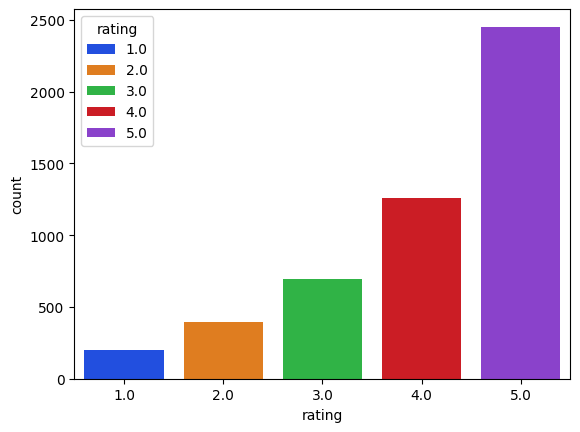

In [ ]:
sns.countplot(comp, x="rating", hue="rating", palette=sns.color_palette("bright"))

Examining the distirbution of ratings, we can see that ratings are highly skewed towards the right with most reviews giving restaurants a 4 or a 5.
We would expect that there is a higher number of low ratings for negative reviews but that does not seem to be the case.

<ipython-input-27-b9c75a5a2934>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  comp_mp['price_adjusted'] = comp_mp['price'].str.replace('\$','\\$')
<ipython-input-27-b9c75a5a2934>:3: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='price_adjusted', data=comp_mp, hue="price_adjusted", palette=sns.color_palette("bright"))


<Axes: xlabel='price_adjusted', ylabel='count'>

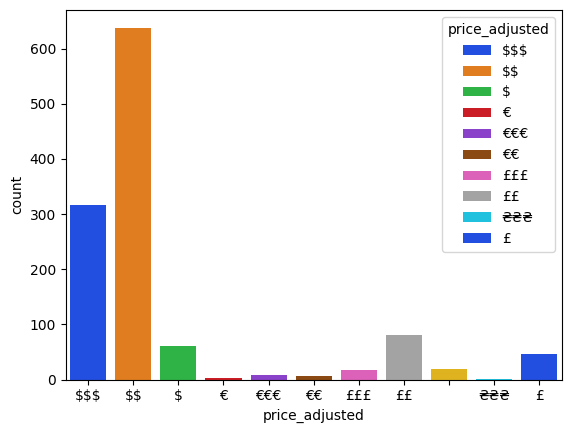

In [ ]:
comp_mp = comp.copy()
comp_mp['price_adjusted'] = comp_mp['price'].str.replace('\$','\\$')
sns.countplot(x='price_adjusted', data=comp_mp, hue="price_adjusted", palette=sns.color_palette("bright"))

Most of the price labels fall under the \$\$ label with the second most falling under the \$\$\$. This could be indicative of businesses trying to stay within a band of affordability.

<Axes: xlabel='price_adjusted', ylabel='rating'>

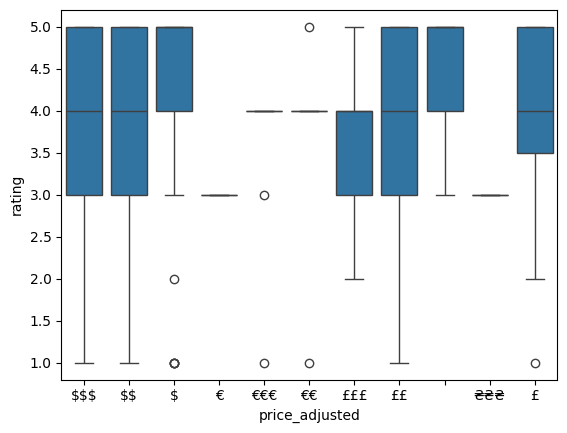

In [ ]:
sns.boxplot(x='price_adjusted', y='rating', data=comp_mp)

Here we try to plot the relationship between price labels and ratings to see if there is any correlation. What we find is that higher price labels may actually have lower ratings than lower price labels. Despite this, most price labels still tend to fall within a average rating of a four or a five.

<Axes: xlabel='reviewLength', ylabel='Count'>

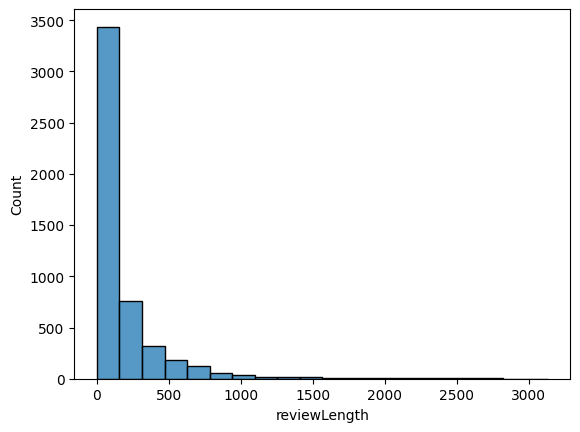

In [ ]:
comp_mp.dtypes
comp_mp['reviewText'] = comp_mp['reviewText'].astype('str')
comp_mp['reviewLength'] = comp_mp['reviewText'].apply(len)
sns.histplot(data=comp_mp, x='reviewLength', bins=20)

Examining the length of reviews, we find that most reviews are shorter in length as the histogram is very left skewed.

<Axes: xlabel='price_adjusted', ylabel='reviewLength'>

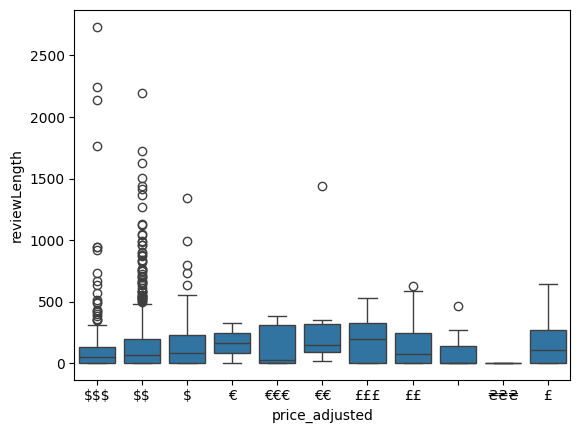

In [ ]:
sns.boxplot(x='price_adjusted', y='reviewLength', data=comp_mp)

In plotting the relationship between review length and price labels, we find that most price labels have similar mean review lengths but our \$\$ and \$\$\$ have far more outliers than \$ which is interesting and might be an area to explore.

We decided not to include any scatterplots in examining the distribution of our data because most of our data is either categorical, free text, or some object representation (time, geographic) which thus made scatterplots ill suited for examining the data.

#Missing Data

In [ ]:
comp.shape

(5000, 11)

In [ ]:
comp.isnull()

,rating,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,name,price,address,closed,gps
0,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,False,False,False,False,False,True,False,False,False
4996,False,False,False,False,False,False,False,True,False,False,False
4997,False,True,False,False,False,False,False,True,False,False,False
4998,False,True,False,False,False,False,False,True,False,False,False


In [ ]:
#find number of rows that are missing data and which columns specifically
comp.isnull().sum()

rating               0
reviewText        1527
categories         348
gPlusPlaceId         0
unixReviewTime     303
reviewTime         303
name                 1
price             3803
address              1
closed               1
gps                 15
dtype: int64

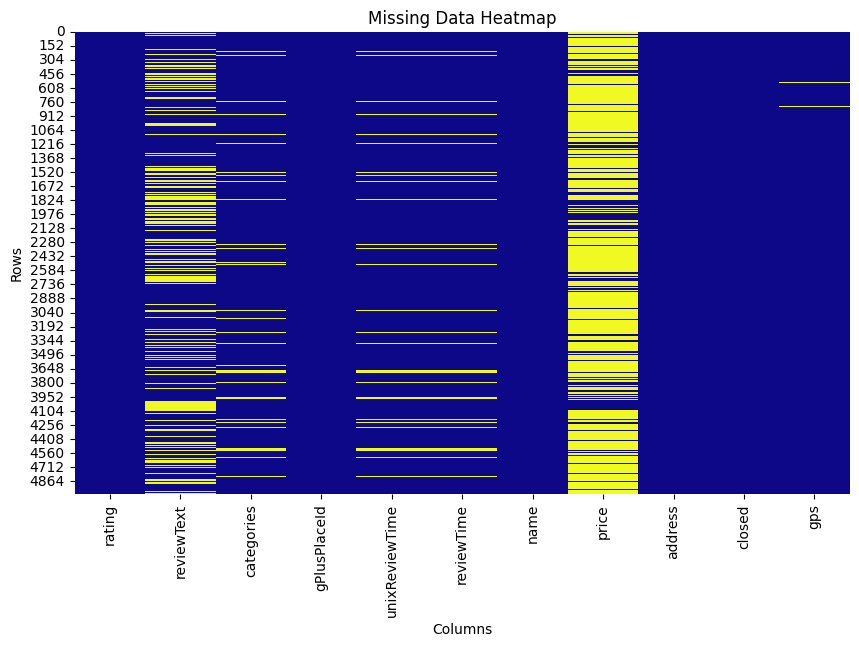

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(comp.isnull(), cmap = 'plasma', cbar=False)
plt.title('Missing Data Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

#yellow refers to missing data and at which observation it is missing

In [ ]:
#list rows with missing data
rows_with_missing_data = comp[comp.isnull().any(axis=1)]
print(rows_with_missing_data)

#can't necessarily filter because majority of the reviews simply have no review text

      rating                                         reviewText  \
0        3.0                                  Chất lượng tạm ổn   
1        5.0                              Wc si temiz duzenli..   
2        5.0                   何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗   
3        5.0  今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...   
4        4.0                            気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗   
...      ...                                                ...   
4995     5.0  Sehr empfehlenswert! Top Felgen-Reparatur, seh...   
4996     2.0  Rindsentrecote auf heissem Stein: Wurde zusätz...   
4997     5.0                                               None   
4998     1.0                                               None   
4999     5.0                                               None   

                                             categories  \
0                                     [Giải Trí - Café]   
1                                     [Turkish Cuisine]   
2         [Fishing

# Imputation

- Normalization vs standardization - ARMAAN
- Data Encoding: label encoding vs one hot encoding
   - Making the price labels (dollars) --> ordinal categories - RISAB
   - Breaking down the name? (ex: does "The", "A", "Shop" change how much $ usually charged?) - JUSTIN
   - Categories of restaurants (cuisine, etc.) - EMILY
   - Latitude/longitude/address --> geographic area - QINGTONG
   - Time (text) --> time object - VIRAJ
   - Sentiment analysis for reviews - JOEY
     - Bag of Words? TF-IDF?
     - Description (sentiment analysis - null or not?)
- Data transformation
   - Standardize/normalize data? - QINGTONG
- Data imputation - nulls - EMILY

#Imputing Null Data

In [ ]:
#make copy of comp because don't want to manipulate main dataframe others are using
comp_copy = comp

In [ ]:
#list the number of missing values and adjust for each row because each row has different values
comp.isnull().sum()

rating               0
reviewText           0
categories         348
gPlusPlaceId         0
unixReviewTime     303
reviewTime         303
name                 1
price             3803
address              1
closed               1
gps                 15
dtype: int64

In [ ]:
#make all review text data an empty string
#take care of this case in data analysis
comp['reviewText'].fillna('', inplace=True)

In [ ]:
#maybe we can use other values to predict a category or make a new category that makes sense
comp['categories'].fillna('Other', inplace=True)

In [ ]:
#fill out this information with unknowns
#assume closed is false --> significant amount of data shows that closed is usually false
#can use essentially the mode in this case
comp['name'].fillna('Unknown', inplace=True)
comp['address'].fillna('Unknown', inplace=True)
comp['closed'].fillna(False, inplace=True)
comp['gps'].fillna('Unknown', inplace=True)

In [ ]:
#imputing missing values for time using the mean
#may not be most effective method
#making an assumption that a majority of these reviews were made at the same time which could skew data when training
comp['unixReviewTime'].fillna(comp['unixReviewTime'].mean(), inplace=True)
comp['reviewTime'].fillna(comp['reviewTime'].mean(), inplace=True)

In [ ]:
price_value_counts = comp['price'].value_counts()
print(price_value_counts)
#given that the majority of the data is missing, unsure if we can trust mode, mean, median
#as a reliable way to fill out null values under the price column

$$     638
$$$    316
££      81
$       60
£       47
        19
£££     17
€€€      9
€€       7
€        2
₴₴₴      1
Name: price, dtype: int64


## Categorizing Data (Emily)

### Determining which entries are restaurant/food related (and therefore relevant to our project)

In [ ]:
#Converting categories of restaurants
#I should get the...main category/most categorizing? category?
#See top_category from EDA:

comp.groupby('top_category').count()['rating'].sort_values(ascending=False)

#Uh-oh...We can see several reviews are for shops, oil changes, department stores, etc. that are UNRELATED to restaurants!

KeyError: 'top_category'

In [ ]:
#So let's determine how similar each "top category" is to "restaurant" using Word2Vec!
import gensim

In [ ]:
#!pip install --upgrade gensim

In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300') #Download Google API to compute word similarity to

In [ ]:
def similar(category, threshold=0.5):
  sims = []
  if category is None:
    return False

  for word in category.split():
    if word in wv:
      sims.append(wv.similarity(word, 'restaurant'))
    else:
      sims.append(0)

  return max(sims) > threshold

In [ ]:
relevant_category = comp['top_category'].apply(similar)

In [ ]:
comp['relevant_cat'] = relevant_category

In [ ]:
comp.head(2)

In [ ]:
#About 3/5 of all categories were decided to be not relevant, the other 2000 are included
relevant_category.value_counts()

In [ ]:
#We can do a quick spot check to see if the results are to our liking:

#comp[comp.relevant_cat].head(10)
#comp[comp.relevant_cat==False].head(10)

#Looks pretty good! :D

### Define df as only relevant data entries

In [ ]:
indexRel = comp[comp.relevant_cat == False].index
df = comp.drop(indexRel, inplace=True)

In [ ]:
df = comp

### Group categories together based on similar restaurant vibes

#### Use TF-IDF score to find most unique "defining" words of restaurant vibe

Define the TF-IDF dictionary

In [ ]:
#Let's find the most unique/defining word in the group using TF-IDF:
from sklearn.feature_extraction.text import TfidfVectorizer

cats_comp = list(df.top_category) #Train on the top_category for every relevant input

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cats_comp)

tfidf_dict = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))

#tfidf_dict

In [ ]:
df.top_category.head(10)

Apply the TF-IDF dictionary to find the most defining word of the "top_category"

In [ ]:
def def_cat(category):
  words = {}

  category = category.lower().replace("restaurant", "") #Had to edit filtering requirements because too many restaurants were just categorized as "restaurant"

  if category is None:
    return None

  for word in category.split():
    if word in tfidf_dict:
      words[word] = tfidf_dict[word]

  if len(words) > 0:
    sorted_words = dict(sorted(words.items(), key=lambda item: item[1]))
    return list(sorted_words.keys())[-1]
  else:
    return "restaurant" #if the only category word is "restaurant" we need a catchall

In [ ]:
def_cat('Steak House')

In [ ]:
kw = df.top_category.apply(def_cat)
kw.value_counts()

#### Use TF-IDF to cluster restaurants based on key word

In [ ]:
# Compute similarity scores between words
similarity_matrix = []
for word1 in list(kw): #For each word in kw
  similarity_scores = []
  for word2 in list(kw): #Compare to the other words in kw (kw = keyword in category)
    if word2 in wv and word1 in wv:
      similarity_scores.append(wv.similarity(word1, word2)) #Return the similarity score if kw is in wv training library
    else:
      similarity_scores.append(0) #Return a similarity of 0 if can't find it
  similarity_matrix.append(similarity_scores)

#Runtime should be about 1m

In [ ]:
from sklearn.cluster import KMeans

# Perform K-means clustering
num_clusters = 5  # I want 5 clusters for now
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(similarity_matrix)
cluster_labels = kmeans.labels_

#Runtime: 5s

In [ ]:
#Assign each keyword in kw to a cluster
word_clusters = {}
cat_list = []
for i, word in enumerate(list(kw)):
  cluster_id = cluster_labels[i] #Get the cluster id = what kmeans grouped as in prev cell
  cat_list.append(cluster_id)
  if cluster_id not in word_clusters: #If this is a new cluster #, create a list to start storing keywords
      word_clusters[cluster_id] = []
  word_clusters[cluster_id].append(word) #Add the keyword to word_clusters[number]

In [ ]:
# Print word clusters
for cluster_id, words in word_clusters.items():
    print(f"Cluster {cluster_id}: {words}")

#My 3-clusters look like: 1. restaurants, 2. american/foreign cuisines, 3. american/hamburger/deli/house
#My 5-clusters look like: 1. bars, cafes, delis, bistros 2. foreign cuisines, 3. bbq/pizza/food, 4. restaurants, 5. family, delivery, house, eclectic

#### Add cluster number as category for restaurant

In [ ]:
df['cat_cluster'] = pd.Series(cat_list)

In [ ]:
df

Emily Note: I need to restart the runtime every time I run through all of my process because it takes up 9.6 GB of system RAM 🥲

Describe how we're going to preprocess

NOTE: This is going to be copy-pasted into the README on Github -- this text box is just for collaboration so we can all write it together

Preprocessing that EMILY did:
- Converted categories to "top_category" to filter out relevant entries only
- Translated reviews into English (noted original language)
- Removed irrelevant fields like phone number, user_id, etc.

## Sentiment Analysis

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def sentiment_analysis_and_charged_words(review):
    sentiment = analyzer.polarity_scores(review)
    charged_words = [word for word in review.split() if analyzer.polarity_scores(word)['compound'] != 0]
    return sentiment, charged_words

def sentiment_analysis_and_charged_words_2(reviews):
    rating_scores = []
    all_words = set()
    charged_words = []
    price_related_keywords = [
        'price', 'cost', 'costly', 'expensive', 'cheap', 'cheapest', 'value', 'best-value', 'money', "money's",
        'worth', 'pricing', 'affordable', 'budget', 'economical', 'budget-friendly',
        'pricey', 'pricy', 'economic', 'bargain', 'deal', 'discount', 'charge', 'fee', 'expense',
        'worth-it', 'sale', 'sales', 'purchase', 'transaction', 'deals',
        'payment', 'payments', 'costly', 'inexpensive', 'cost-effective', 'effective',
        'overpriced', 'underpriced', 'overprice', 'underprice', 'overprices', 'underprices', 'cheaper', 'cheapest', 'pricier', 'priciest',
        'refund', 'income', 'revenue', 'premium', 'garbage', 'inexpensive', 'extravagant', 'boujee', 'rip-off'
        "an arm and a leg", "break the bank", "dent in your wallet", "dent in the wallet", "arm and leg",
         "expensive proposition", "big bucks", "high price", "high cost", "high-price", "high-cost",
        "top dollar", "top-dollar", "cost a pretty penny", "pretty penny", "cost a fortune"
    ]
    review = reviews.lower()
    for word in price_related_keywords:
      if word in review:
        charged_words.append(word)

    return list(set(charged_words))


df['sentiment'], df['charged_words'] = zip(*df['translated'].apply(lambda x: sentiment_analysis_and_charged_words(x)))
df['price_words'] = df['translated'].apply(sentiment_analysis_and_charged_words_2)

In [ ]:
sum(x.apply(lambda y: y == []))

1943

## Data Evaluation


#### ***Reviews Dataset***:

- **Row** - Corresponds to one review
- **Columns (6)**
    - **rating**: *float64* - A value from [1, 2, 3, 4, 5]
    - **reviewText**: *object* - review text of the specific business
    - **categories**: *object* - List of Categories associated with the business
    - **gPlusPlaceId**: *object* - Id associated with the business
    - **unixReviewTime**: *float64* - Represents the time the review was made in Unix Formatted time
    - **reviewTime**: *object* - Represents the time the review was made in human-readable format

#### ***Places Dataset***:

- **Row** - Corresponds to one place
- **Columns (6)**
    - **name**: *object* - Name of the place
    - **price**: *object* - categorical price-range of the business, ranges from $ to $$$$
    - **address**: *object* - Address of the place
    - **closed**: *bool* - True if place is closed False otherwise
    - **gPlusPlaceId**: *object* - Id associated with the place
    - **gps**: *object* - Latitude and Longitude of location of the place

#### ***Added Columns****
- **Row** - Corresponds to one review
- **Columns (8)**
    - **language**: *String* - Language of the review
    - **translated**: *String* - English text of the review, translated into English if not anlready in English
    - **top_category**: *String* - Top category associated with the business
    - **relevant_cat**: *bool* - True if top_category is related to a restaurant, False if otherwise
    - **cat_cluster**: *float64* - Cluster restaurants into one of 5 categories based on top_category
    - **sentiment**: *object* - Sentiment analysis of the review. Includes negative, neutral, and positive sentiment as well as the compounded sentiment (overall sentiment based on negative, neutral, and positive sentiment)
    - **charged_words**: *object* - List of words that influenced the sentiment analysis of the review
    - **price_words**: *object* - List of words relating from the review that relate to their opinion of the pricing of the business


In [ ]:
reviews.head()

In [ ]:
reviews.dtypes

In [ ]:
reviews['rating'].unique()

In [ ]:
places.head()

In [ ]:
places.dtypes

In [ ]:
comp.dtypes

In [ ]:
comp.head()

## Breaking Down Names of Restaurants

In [ ]:
# Only consider restaurants with non-null price value
df_has_price = comp[(~comp['price'].isnull()) & (comp['price'] != '')]

In [ ]:
print("rows: ", df_has_price.shape[0])
df_has_price.head(5)

# 1178 out of 5000 reviews include the price

In [ ]:
# Price Indicators
# $ = Inexpensive, usually $10 and under
# $$ = Moderately expensive, usually between $10-$25
# $$$ = Expensive, usually between $25-$45
# $$$$ = Very Expensive, usually $50 and up'

df_has_price['price'].unique()

In [ ]:
# Join all names
all_names = ' '.join(df_has_price['name'].astype(str))

# Split into words
words = re.findall(r'\b[\w\']+\b', all_names)

# Count the frequency of each word
word_counts = Counter(words)

# Sort by word frequency
word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Count the number of unique words
num_unique_words = len(word_counts)

In [ ]:
print("Top 20 Most Common Words in Restaurant names:")
for word_count in list(word_counts.items())[:20]:
  print(word_count)

print("\nnumber of unique words: ", num_unique_words)

In [ ]:
def convert_to_usd(symbol):
  conversion = { '$': 1, '€': 1.08, '£': 1.26, '₴': 0.027}
  if symbol[0] not in conversion:
    return 0
  # $ = $10, $$ = $20, $$$ = $30
  return 10 * len(symbol) * conversion[symbol[0]]

def convert_to_symbol(dollars):
  # $ = Inexpensive, usually $10 and under
  # $$ = Moderately expensive, usually between $10-$25
  # $$$ = Expensive, usually between $25-$45
  # $$$$ = Very Expensive, usually $50 and up'
  if dollars < 10:
    return '$'
  elif dollars < 25:
    return '$$'
  elif dollars < 45:
    return '$$$'
  return '$$$$'

# calculate cumulative prices for each word
word_prices = {key: 0 for key in word_counts}
for index, restaurant in df_has_price.iterrows():
  name, price = restaurant['name'], convert_to_usd(restaurant['price'])
  words = re.findall(r'\b[\w\']+\b', name)
  for word in words:
    word_prices[word] += price

for word, cuma_price in word_prices.items():
  average_price = round(cuma_price / word_counts[word], 2)
  word_prices[word] = (average_price, convert_to_symbol(average_price), word_counts[word]) # restaurant_name: (average_price, symbol for average_price, total occurrences of word in restaurant names)

# Sorting by word counts
word_prices = dict(sorted(word_prices.items(), key=lambda item: item[1][2], reverse=True))


In [ ]:
for word_price in list(word_prices.items())[:30]:
  print(word_price)

## Geographical Location

In [ ]:
comp.head()

,rating,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,name,price,address,closed,gps
0,3.0,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,2013-07-01 13:50:59,2013-07-01,Cà Phê Thăng Long,None,"[22 Phạm Văn Chiêu, 13, Gò Vấp, Hồ Chí Minh, V...",False,"[10.852044, 106.65971]"
1,5.0,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,2012-07-21 11:38:44,2012-07-21,Selale Restaurant,None,[Pınarkent Bld. Atatürk Cd. Pk:20145 Denizli M...,False,"[37.8037, 29.2209]"
2,5.0,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,2014-01-25 12:38:33,2014-01-25,Sakana no Hokushin,None,"[1 Chome-4-1 Izumichuo, Izumi Ward, Sendai, Mi...",False,"[38.323455, 140.882111]"
3,5.0,今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...,[Museum],101477177500158511502,2014-01-08 13:28:26,2014-01-08,教育資料館,None,"[Sakurakoji-6 Toyomamachi Teraike, Tome, Miyag...",False,"[38.655345, 141.27981]"
4,4.0,気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗,[Police],106994170641063333085,2014-01-23 14:11:19,2014-01-23,気仙沼警察署（仮）,None,"[Japan, 〒988-0181, 宮城県気仙沼市赤岩杉ノ沢４７－６]",False,"[38.88735, 141.56932]"


new dataframe for geographical location

In [ ]:
df_geo = pd.DataFrame(comp[['gPlusPlaceId', 'address']])

In [ ]:
df_geo = df_geo.assign(latitude = comp[comp['gps'].notna()]['gps'].apply(lambda x: x[0]))
df_geo = df_geo.assign(longitude = comp[comp['gps'].notna()]['gps'].apply(lambda x: x[1]))

In [ ]:
df_geo = df_geo[df_geo['latitude'].notna()]

In [ ]:
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

Using KMeans clustering to cluster locations into groups

In [ ]:
## can adjust k based on needs
kmeans = KMeans(n_clusters = 200, random_state=42)
df_geo['location_cluster'] = kmeans.fit_predict(df_geo[['latitude', 'longitude']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
(df_geo['address'][0])

['22 Phạm Văn Chiêu', '13, Gò Vấp', 'Hồ Chí Minh, Vietnam']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

convert (latitude, longitude) to a location object

In [ ]:
#takes 42m
def reverse_geocode(row):
    try:
        # Ensure valid latitude and longitude values
        if -90 <= row['latitude'] <= 90 and -180 <= row['longitude'] <= 180:
            geolocator = Nominatim(user_agent="restaurant_locator")
            location = geolocator.reverse((row['latitude'], row['longitude']))
            return location
        else:
            return "Invalid coordinates"
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"Geocoding error: {e}")
        return None

# Assuming df_geo is your DataFrame with 'latitude' and 'longitude' columns
df_geo['location'] = df_geo.apply(reverse_geocode, axis=1)

Geocoding error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=39.102853&lon=-94.441083&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


In [ ]:
df_geo.head()

,gPlusPlaceId,address,latitude,longitude,location_cluster,location
0,108103314380004200232,"[22 Phạm Văn Chiêu, 13, Gò Vấp, Hồ Chí Minh, V...",10.852044,106.659710,107,"(596, Phạm Văn Chiêu, Phường 16, Quận Gò Vấp, ..."
1,102194128241608748649,[Pınarkent Bld. Atatürk Cd. Pk:20145 Denizli M...,37.803700,29.220900,73,"(Koyunaliler, Pınarkent, Pamukkale, Denizli, E..."
2,101409858828175402384,"[1 Chome-4-1 Izumichuo, Izumi Ward, Sendai, Mi...",38.323455,140.882111,57,"(セルバ, 泉中央通り（県道仙台泉線）, 泉中央四丁目, 泉区, 仙台市, 宮城県, 981..."
3,101477177500158511502,"[Sakurakoji-6 Toyomamachi Teraike, Tome, Miyag...",38.655345,141.279810,57,"(教育資料館, 築館登米線, 登米町日野渡, 登米市, 宮城県, 987-0702, 日本,..."
4,106994170641063333085,"[Japan, 〒988-0181, 宮城県気仙沼市赤岩杉ノ沢４７－６]",38.887350,141.569320,57,"(気仙沼唐桑線, 赤岩舘下, 気仙沼市, 宮城県, 988-0181, 日本, (38.88..."


location.raw outputs a dictionary of geo info

In [ ]:
df_geo['location'][0].raw

{'place_id': 256494183,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'node',
 'osm_id': 6791368648,
 'lat': '10.8522389',
 'lon': '106.6602114',
 'class': 'place',
 'type': 'house',
 'place_rank': 30,
 'importance': 9.99999999995449e-06,
 'addresstype': 'place',
 'name': '',
 'display_name': '596, Phạm Văn Chiêu, Phường 16, Quận Gò Vấp, Thành phố Hồ Chí Minh, 71500, Việt Nam',
 'address': {'house_number': '596',
  'road': 'Phạm Văn Chiêu',
  'quarter': 'Phường 16',
  'suburb': 'Quận Gò Vấp',
  'city': 'Thành phố Hồ Chí Minh',
  'ISO3166-2-lvl4': 'VN-SG',
  'postcode': '71500',
  'country': 'Việt Nam',
  'country_code': 'vn'},
 'boundingbox': ['10.8521889', '10.8522889', '106.6601614', '106.6602614']}

## price one-hot encoding

In [ ]:
def convert_to_usd(symbol):
  conversion = { '$': 1, '€': 1.08, '£': 1.26, '₴': 0.027}
  if symbol[0] not in conversion:
    return 0
  # $ = $10, $$ = $20, $$$ = $30
  return 10 * len(symbol) * conversion[symbol[0]]

def convert_to_symbol(dollars):
  # $ = Inexpensive, usually $10 and under
  # $$ = Moderately expensive, usually between $10-$25
  # $$$ = Expensive, usually between $25-$45
  # $$$$ = Very Expensive, usually $50 and up'
  if dollars < 10:
    return '$'
  elif dollars < 25:
    return '$$'
  elif dollars < 45:
    return '$$$'
  return '$$$$'

In [ ]:
# Only consider restaurants with non-null price value
df_price_encoding = comp[(~comp['price'].isnull()) & (comp['price'] != '')]

In [ ]:
df_price_encoding['price'] = df_price_encoding['price'].apply(convert_to_usd)

<ipython-input-26-f447efb0eebc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_encoding['price'] = df_price_encoding['price'].apply(convert_to_usd)


In [ ]:
df_price_encoding['price'] = df_price_encoding['price'].apply(convert_to_symbol)

<ipython-input-28-adba87819cdf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_encoding['price'] = df_price_encoding['price'].apply(convert_to_symbol)


In [ ]:
df_price_encoding = pd.get_dummies(df_price_encoding, columns=['price'], prefix='Class')

In [ ]:
df_price_encoding

,rating,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,name,address,closed,gps,Class_$$,Class_$$$
13,4.0,Best War Wanton soup in Red Bluff,"[Asian Restaurant, Chinese Restaurant]",106591714648856494903,2014-03-13 00:11:36,2014-03-12,Peking Chinese Restaurant,"[860 Main St, Red Bluff, CA 96080]",False,"[40.179159, -122.236162]",0,1
14,5.0,This is a review that is long overdo. I've bee...,"[European Restaurant, Italian Restaurant, Pizz...",109420033090810328045,2014-03-14 19:46:28,2014-03-14,Firehouse Pizza,"[734 Main St, Red Bluff, CA 96080]",False,"[40.178074, -122.235234]",1,0
17,5.0,"Long time favorite Mexican food, always consis...",[Mexican Restaurant],115827996910815192564,2014-03-13 00:15:13,2014-03-12,La Corona,"[914 Walnut St, Red Bluff, CA 96080]",False,"[40.175064, -122.242574]",1,0
27,2.0,Open 24 hours is a plus but really slow. Sat i...,[Restaurant],100073820849130920147,2013-08-11 06:45:30,2013-08-10,Hardee's / Red Burrito,"[134 N Hills St, Meridian, MS 39305]",False,"[32.413658, -88.677648]",0,1
28,2.0,We ordered two large pizzas during the any piz...,"[Pizza Restaurant, European Restaurant]",102333498482915416504,2013-09-03 01:12:38,2013-09-02,Pizza Hut,"[2199 S Byron Butler Pkwy, Perry, FL 32348]",False,"[30.09469, -83.580572]",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4979,5.0,We love Thai Basil...even our kids love it. Th...,"[Asian Restaurant, Southeast Asian Restaurant,...",101587451978256702592,2008-03-04 01:28:19,2008-03-03,Thai Basil,"[7882 N Academy Blvd, Colorado Springs, CO 80920]",False,"[38.946789, -104.802123]",1,0
4980,3.0,"Fun NY style pie. Not overwhelmed, like, ""Oh m...","[Pizza Restaurant, European Restaurant, Italia...",103760597537950808267,2011-04-27 23:33:57,2011-04-27,Borriello Brothers Thin Crust Pizza,"[215 E Platte Ave, Colorado Springs, CO 80903]",False,"[38.837789, -104.82037]",1,0
4981,5.0,There new men features a variety of beef dips!...,"[American Restaurant, Deli, Sandwich Shop]",113111376675126375684,2011-02-05 19:35:47,2011-02-05,Deli Dave's,"[360 S Mcculloch Blvd, Pueblo West, CO 81007]",False,"[38.320408, -104.746928]",1,0
4982,4.0,"Great food, passionate owner! Love the Noodle ...","[Asian Restaurant, Southeast Asian Restaurant,...",113731582730578350193,2013-04-30 17:05:58,2013-04-30,Pho 888,"[539 Sable Blvd, Aurora, CO 80011]",False,"[39.724134, -104.821328]",1,0
